In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import sympy as smp
from tqdm import tqdm
from sympy import Symbol, symbols
import centrex_TlF as centrex
import matplotlib.pyplot as plt
from julia import Main

### Papermill parameters

In [2]:
Γ = 2*np.pi*1.56e6

transition_type = "R"
ground_J = 1
excited_J = 2
excited_F = 2
excited_F1 = 3/2
system_J = [1,3]

laser_power = 23.8e-3 # power in W
σlaser = 0.000914
npasses = 9
multipass_offset = 0.01
distance_between_passes = 0.03556/npasses
power_loss_per_pass = 20.2/23.8

vcm = 150

ωp = 0.65*Γ

β = 3.8
ωphase = 0.0

scan_range = [-10,10.25,0.25]

nprocs = 7

In [3]:
# Parameters
transition_type = "Q"
excited_J = 1
excited_F = 1
excited_F1 = 1.5
system_Js = [1, 3]


In [4]:
trans = centrex.transitions.LaserTransition(
    f"{transition_type}{ground_J}",
    F1 = excited_F1,
    F = excited_F
)
trans

Transition(Q(1) F1'=3/2 F'=1)

In [5]:
excited_state = centrex.states.QuantumSelector(
                    J=excited_J, F=excited_F, F1=excited_F1, 
                    electronic = 'B', P = trans.excited_selector.P
)
print(f"excited state : {excited_state}")

excited state : QuantumSelector(J=1, F1=1.5, F=1, mF=None, electronic='B', P=1, Ω=None)


# Initial setup
## Involved states

In [6]:
gnd = centrex.states.QuantumSelector(J=system_J, electronic = 'X')
exc = excited_state

gnd_laser = centrex.states.QuantumSelector(J=trans.ground_selector.J, electronic = 'X')
exc_laser = excited_state

In [7]:
syspars = centrex.states.SystemParameters(
    nprocs  = nprocs,
    Γ       = Γ,
    X  = gnd,
    B = [exc]
)

## Parameters

In [8]:
odepars = centrex.lindblad.odeParameters(
    Ωl = "Ωl0 * phase_modulation(t, β, ωphase) * multipass_2d_intensity(vz*t, y0+vy*t, ampl, xlocs, ylocs, σzlaser, σylaser)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δl      = 0.0,              # detuning of the laser [rad/s]
    
    # laser beam properties
    σzlaser = σlaser * np.sqrt(2),
    σylaser = σlaser * np.sqrt(2),
    
    # laser multipass
    ampl = [np.sqrt(power_loss_per_pass**n) for n in range(npasses)],
    xlocs = [(n-1)*distance_between_passes + multipass_offset for n in centrex.utils.light.multipass_prism_order(npasses)],
    ylocs = npasses*[0.0],
    
    # laser phase modulation
    ωphase = ωphase,       # laser phase modulation frequency [rad/s]
    β      = β,             # laser phase modulation depth [rad]

    # laser polarization switching
    ωp = ωp,           # polarization switching frequency [rad/s]
    φp = 0.0,                 # polarization switching phase [rad]
    Pl  = "sin(ωp*t + φp)",
    Plz = "Pl>0",
    Plx = "Pl<=0",
    Ply = 0.0,
    
    # molecules
    y0 = 0.,                   # molecule start y position [m]
    vz = vcm,                 # longitudinal molecular velocity [m/s]
    vy = 0.,                   # molecule vy [m/s]
)


## Transitions

In [9]:
transitions = [
    centrex.couplings.TransitionSelector(
        ground = 1*centrex.states.generate_coupled_states_ground_X(gnd_laser),
        excited = 1*centrex.states.generate_coupled_states_excited_B(exc_laser),
        polarizations        = [[0,0,1],[1,0,0],[0,1,0]],
        polarization_symbols = symbols("Plz     Plx     Ply"),
        Ω = smp.Symbol('Ωl', complex = True),
        δ = smp.Symbol('δl'),
        description = "laser transition",        
    ),
]

In [10]:
transition_name = centrex.transitions.identify_transition(
    transitions[0].ground[0],
    transitions[0].excited[0]
)
transition_name = transition_name.replace(",","").replace("/","_")
transition_name

"Q(1) F1'=3_2 F'=1"

## Generate System

In [11]:
%%time
obe_system = centrex.lindblad.setup_OBE_system_julia(syspars, odepars, transitions, verbose=True, full_output=True, 
                                                     qn_compact=centrex.states.QuantumSelector(J=3, electronic = 'X'))

[13:01:39] INFO     generate_OBE_system: 1/6 -> Generating the reduced      ]8;id=673107;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=602641;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#88\88]8;;\
                    Hamiltonian

[13:01:43] INFO     generate_OBE_system: 2/6 -> Generating the couplings   ]8;id=963712;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=365419;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#103\103]8;;\
                    corresponding to the transitions

[13:02:01] INFO     generate_OBE_system: 3/6 -> Generating the symbolic    ]8;id=136929;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=817390;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#138\138]8;;\
                    Hamiltonian

[13:02:15] INFO     generate_OBE_system: 4/6 -> Generating the collapse    ]8;id=671202;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=888854;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#149\149]8;;\
                    matrices

[13:02:16] INFO     generate_OBE_system: 5/6 -> Transforming the           ]8;id=42787;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=110841;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#178\178]8;;\
                    Hamiltonian and collapse matrices into a symbolic                        
                    system of equations

[13:02:17] INFO     generate_OBE_system: 6/6 -> Generating Julia code      ]8;id=601378;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=997069;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#186\186]8;;\
                    representing the system of equations

[13:02:25] INFO     setup_OBE_system_julia: 1/3 -> Generating the preamble ]8;id=792428;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=275315;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#266\266]8;;\

           INFO     setup_OBE_system_julia: 2/3 -> Initializing Julia on 7 ]8;id=698587;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=316257;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#270\270]8;;\
                    cores

Initialized Julia with 7 processes


[13:02:57] INFO     setup_OBE_system_julia: 3/3 -> Defining the ODE        ]8;id=38612;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py\utils_setup.py]8;;\:]8;id=66178;file://C:\Users\ogras\anaconda3\lib\site-packages\centrex_tlf-0.2-py3.8.egg\centrex_TlF\lindblad\utils_setup.py#277\277]8;;\
                    equation and parameters in Julia

Wall time: 1min 17s


# Simulations
## Single trajectory for population in each HFS separately

In [12]:
Ωl0 = centrex.utils.light.calculate_rabi_from_power_gaussian_beam(
                        laser_power,
                        obe_system.couplings[0]['main coupling'],
                        σlaser,
                        σlaser
    ).real
print(f"Ωl0 : {Ωl0 / syspars.Γ:.2f} Γ")

Ωl0 : 0.24 Γ


In [13]:
odepars.Ωl0 = Ωl0
odepars.ωphase = ωphase
odepars.ωp = ωp

In [14]:
nphotons = []
res = []
for idx, state in tqdm(enumerate(obe_system.QN), 
                       total = centrex.utils.J_levels(
                           trans.ground_selector.J
                       )
                      ):
    state = state.find_largest_component()
    if (state.J == 1) & (state.electronic_state == 'X'):
        ρ = centrex.utils.generate_population_states([idx], len(obe_system.QN))
        t_array, results = centrex.lindblad.do_simulation_single(odepars, (0,50e-3/odepars.vz+10e-6), ρ)
        res.append({'t': t_array, 'data': results})
        nphotons.append(
            np.trapz(results[exc.get_indices(obe_system.QN),:].sum(axis = 0), t_array)*syspars.Γ
        )

  0%|                                                                                                             | 0/12 [00:00<?, ?it/s]

  8%|████████▍                                                                                            | 1/12 [00:05<01:03,  5.80s/it]

 17%|████████████████▊                                                                                    | 2/12 [00:07<00:32,  3.24s/it]

 25%|█████████████████████████▎                                                                           | 3/12 [00:08<00:20,  2.26s/it]

 33%|█████████████████████████████████▋                                                                   | 4/12 [00:09<00:16,  2.01s/it]

 42%|██████████████████████████████████████████                                                           | 5/12 [00:11<00:11,  1.68s/it]

 50%|██████████████████████████████████████████████████▌                                                  | 6/12 [00:12<00:08,  1.48s/it]

 58%|██████████████████████████████████████████████████████████▉                                          | 7/12 [00:13<00:06,  1.31s/it]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 8/12 [00:14<00:04,  1.24s/it]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 9/12 [00:15<00:03,  1.19s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 10/12 [00:16<00:02,  1.11s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 11/12 [00:17<00:01,  1.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.12s/it]

16it [00:18,  1.15s/it]                                                                                                                  

  0%|                                                                                                             | 0/12 [00:00<?, ?it/s]

  8%|████████▍                                                                                            | 1/12 [00:00<00:04,  2.57it/s]

 17%|████████████████▊                                                                                    | 2/12 [00:00<00:04,  2.49it/s]

 25%|█████████████████████████▎                                                                           | 3/12 [00:00<00:02,  3.56it/s]

 33%|█████████████████████████████████▋                                                                   | 4/12 [00:01<00:01,  4.37it/s]

 42%|██████████████████████████████████████████                                                           | 5/12 [00:01<00:01,  5.07it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 6/12 [00:01<00:01,  5.58it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 7/12 [00:01<00:00,  5.21it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 8/12 [00:01<00:00,  5.46it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 9/12 [00:01<00:00,  5.73it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 10/12 [00:02<00:00,  5.96it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 11/12 [00:02<00:00,  6.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.89it/s]

16it [00:02,  6.66it/s]                                                                                                                  

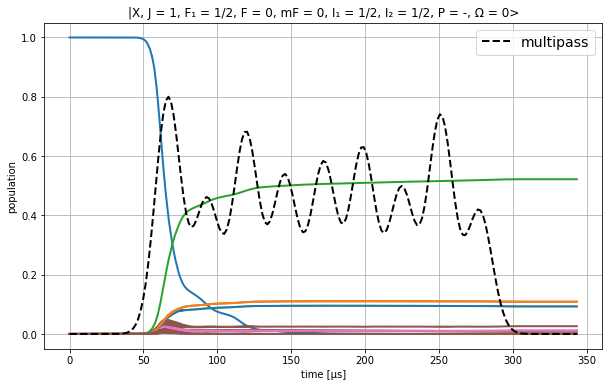

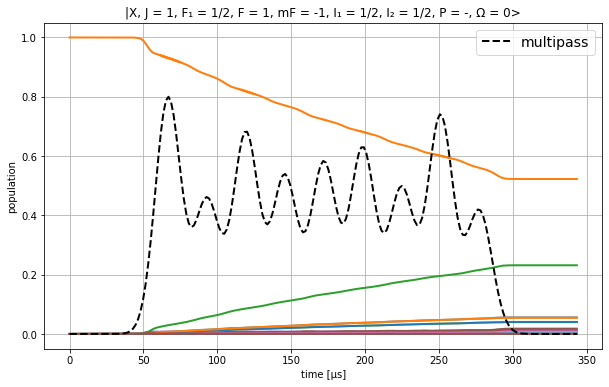

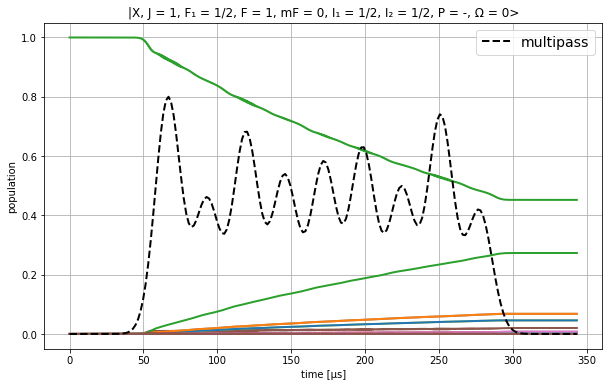

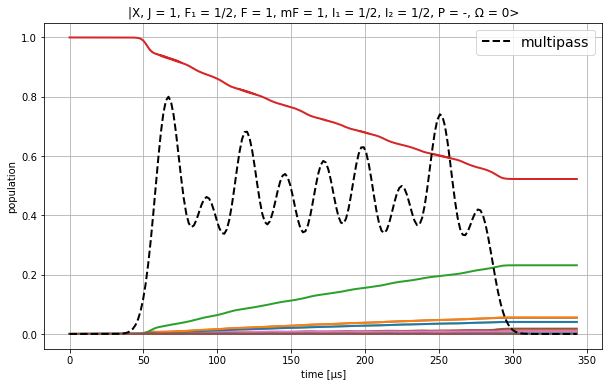

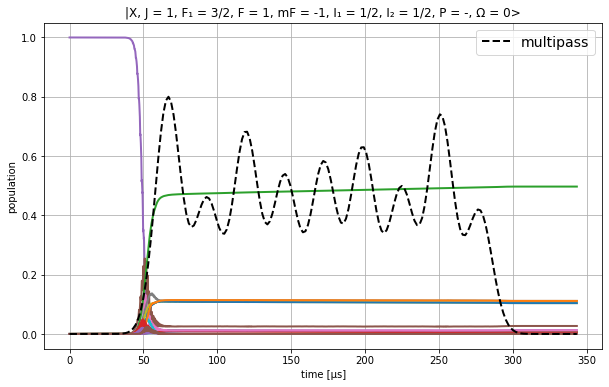

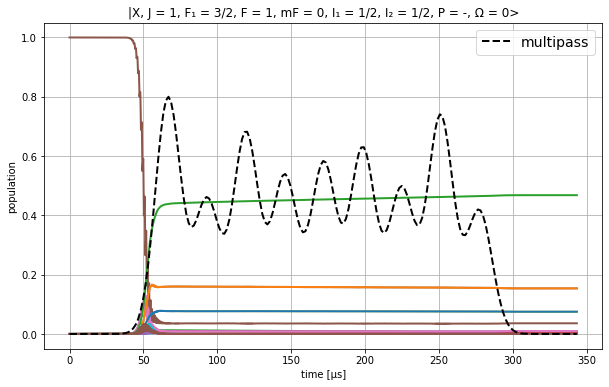

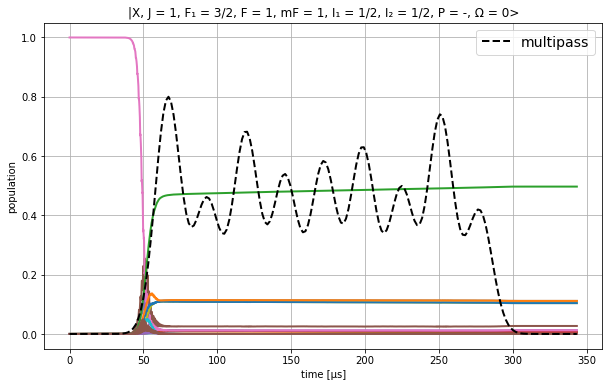

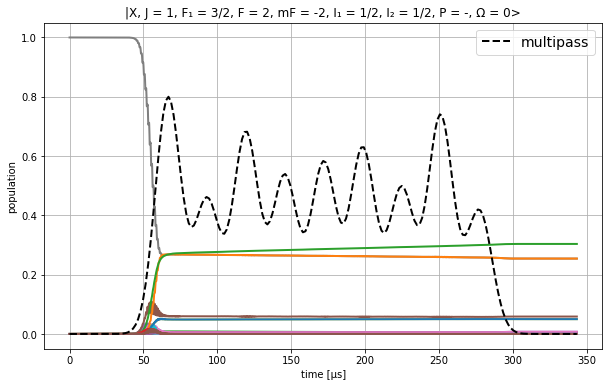

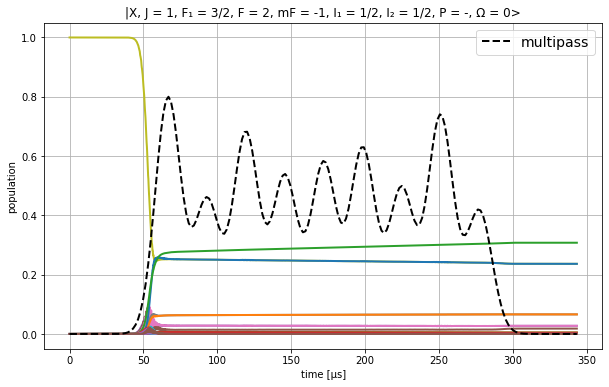

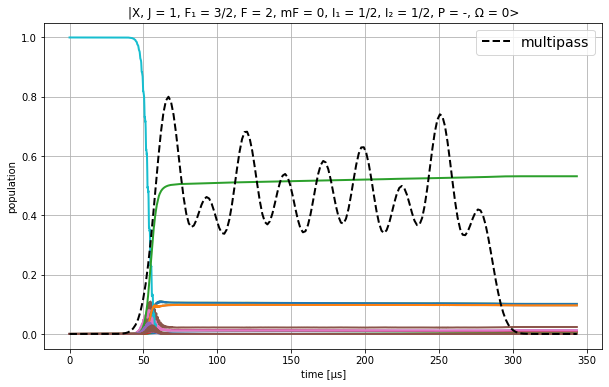

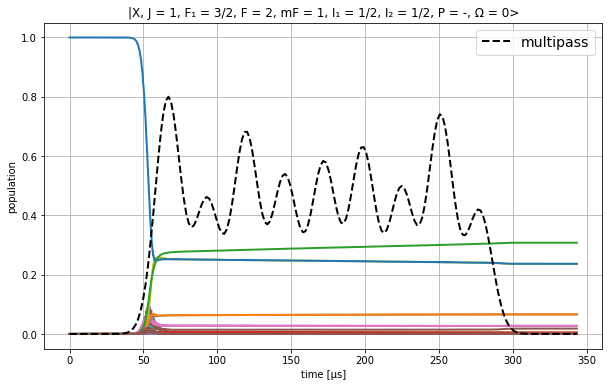

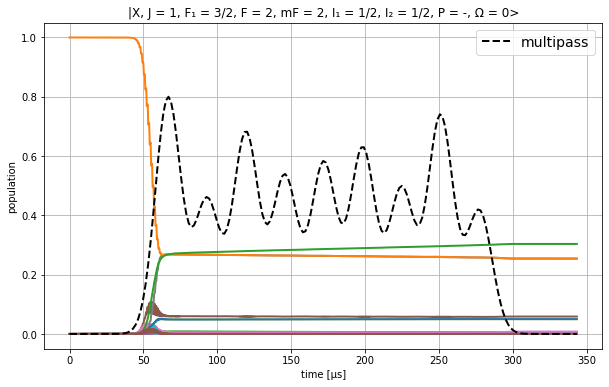

In [15]:
for idx, state in tqdm(enumerate(obe_system.QN), 
                       total = centrex.utils.J_levels(
                           trans.ground_selector.J
                       )
                      ):
    state = state.find_largest_component()
    
    if (state.J == 1) & (state.electronic_state == 'X'):
        t_array, results = res[idx].values()
        _t = np.linspace(t_array.min(), t_array.max(), 201)
        multipass = np.abs(odepars.get_parameter_evolution(_t, "Ωl").real)
        
        fig, ax = plt.subplots(figsize = (10,6)) 
        ax.plot(t_array*1e6, results.T, lw = 2);
        ax.plot(_t*1e6, multipass/multipass.max()*0.8, 'k--', lw = 2,
                label = 'multipass')
        ax.set_xlabel('time [μs]')
        ax.set_ylabel('population')
        ax.set_title(f"{state}")
        ax.legend(fontsize = 14)
        ax.grid(True)

### Calculate Branching ratios

In [16]:
branch = {}
for idx,i,j in zip(*np.nonzero(obe_system.C_array)):
    g = obe_system.QN[i].find_largest_component()
    e = obe_system.QN[j].find_largest_component()
    if trans.ground_selector.J == g.J:
        br = (obe_system.C_array[idx,i,j]**2 / syspars.Γ).real
        key = f"{e.J}, {e.F1}, {e.F}, {e.mF}"
        if branch.get(key) is None:
            branch[key] = br
        else:
            branch[key] += br
branch

{'1, 1.5, 1.0, -1.0': 0.8907056854438347,
 '1, 1.5, 1.0, 0.0': 0.8907056873393692,
 '1, 1.5, 1.0, 1.0': 0.8907056903857858}

### Save Results to pickle file

In [17]:
with open(f"{transition_name}.pkl", "wb") as f:
    pickle.dump(
        dict(
            QN = obe_system.QN,
            results = res,
            nphotons = nphotons,
            branching = branch
        ),
        f
    )

## Detuning Scan

In [18]:
odepars.Ωl0 = Ωl0
odepars.ωphase = ωphase
odepars.ωp = ωp

tspan = (0,1000e-6)

δl_scan = np.arange(*scan_range)*syspars.Γ

parameters = ["δl"]
values = [δl_scan]

output_func = centrex.lindblad.setup_state_integral_calculation(
                states = exc.get_indices(obe_system.QN, mode = "julia"),
                nphotons = True
            )
cb = centrex.lindblad.setup_discrete_callback_terminate(odepars, "vz*t >= 50e-3")

In [19]:
scan_results = []
for idx, state in tqdm(enumerate(obe_system.QN), 
                       total = centrex.utils.J_levels(
                           trans.ground_selector.J
                       )
                      ):
    state = state.find_largest_component()
    if (state.J == 1) & (state.electronic_state == 'X'):
        ρ = centrex.utils.generate_population_states([idx], len(obe_system.QN))

        ens_prob = centrex.lindblad.setup_problem_parameter_scan(
                                odepars, tspan, ρ, parameters, values, 
                                dimensions = 1,
                                output_func = output_func,
                                zipped = True
                    )

        centrex.lindblad.solve_problem_parameter_scan(ensemble_problem_name = ens_prob, saveat = 1e-7,
                                                     callback = cb)
        scan_results.append(centrex.lindblad.get_results_parameter_scan())

  0%|                                                                                                             | 0/12 [00:00<?, ?it/s]

  8%|████████▍                                                                                            | 1/12 [00:32<05:54, 32.21s/it]

 17%|████████████████▊                                                                                    | 2/12 [00:48<03:46, 22.66s/it]

 25%|█████████████████████████▎                                                                           | 3/12 [01:03<02:51, 19.10s/it]

 33%|█████████████████████████████████▋                                                                   | 4/12 [01:18<02:21, 17.68s/it]

 42%|██████████████████████████████████████████                                                           | 5/12 [01:34<01:58, 16.88s/it]

 50%|██████████████████████████████████████████████████▌                                                  | 6/12 [01:48<01:37, 16.18s/it]

 58%|██████████████████████████████████████████████████████████▉                                          | 7/12 [02:03<01:18, 15.72s/it]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 8/12 [02:20<01:04, 16.01s/it]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 9/12 [02:36<00:47, 15.95s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 10/12 [02:51<00:31, 15.88s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 11/12 [03:07<00:15, 15.82s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:23<00:00, 15.88s/it]

16it [03:23, 12.72s/it]                                                                                                                  

  0%|                                                                                                             | 0/12 [00:00<?, ?it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 7/12 [00:00<00:00, 63.81it/s]

16it [00:00, 83.90it/s]                                                                                                                  

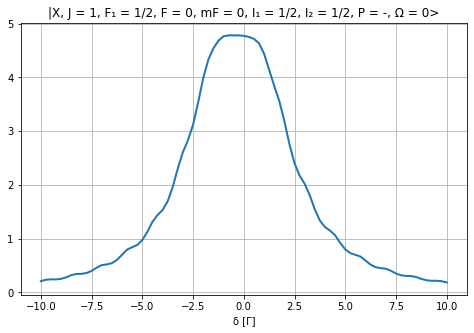

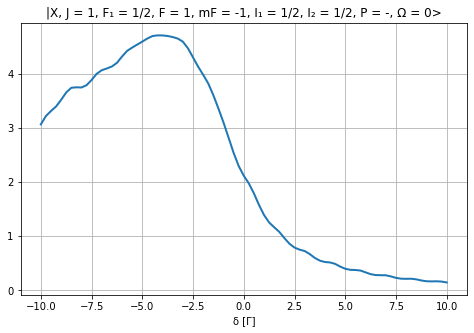

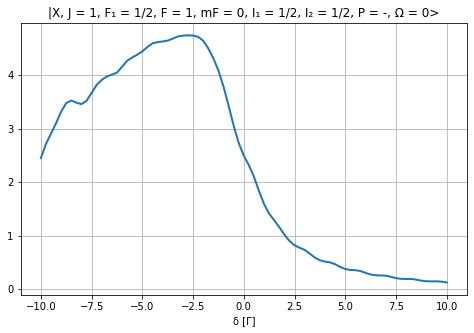

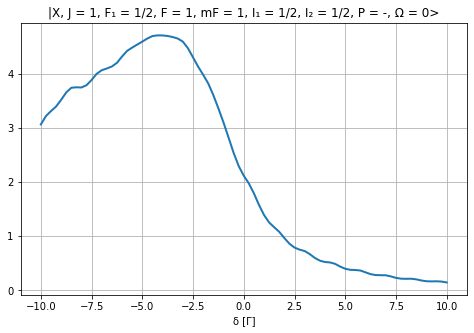

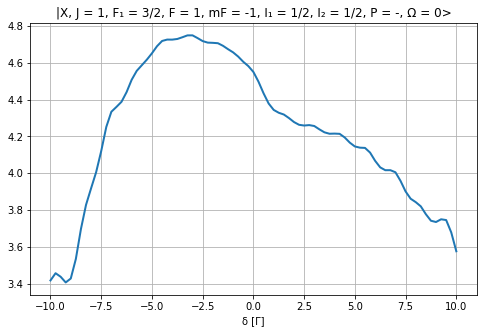

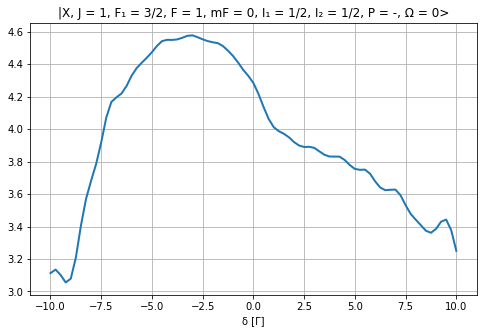

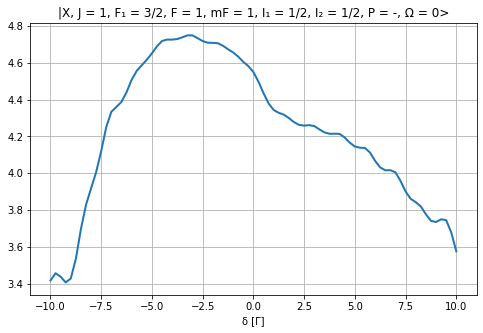

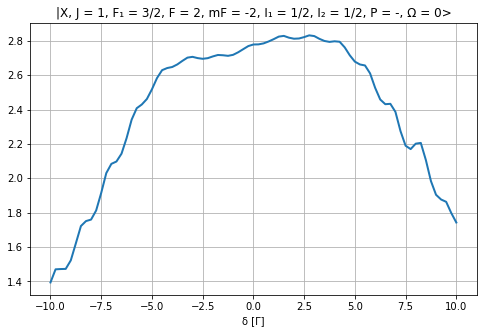

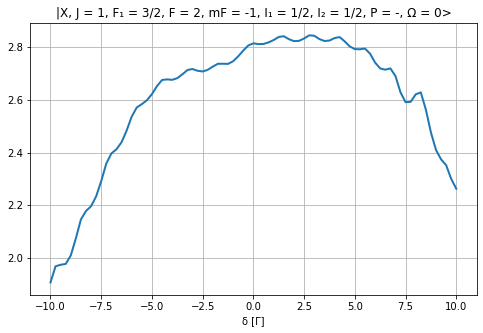

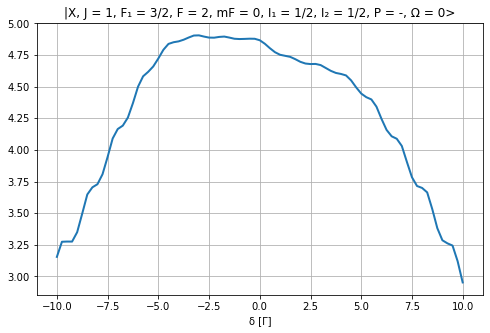

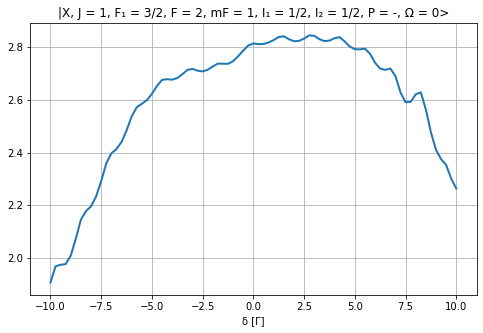

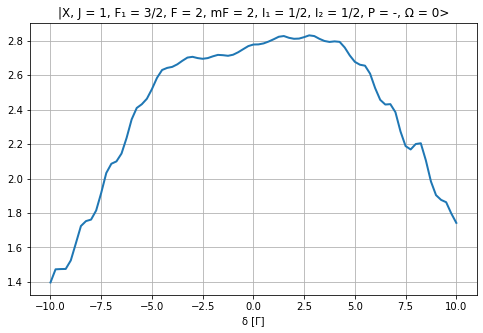

In [20]:
for idx, state in tqdm(enumerate(obe_system.QN), 
                       total = centrex.utils.J_levels(
                           trans.ground_selector.J
                       )
                      ):
    state = state.find_largest_component()
    
    if (state.J == 1) & (state.electronic_state == 'X'):
        results = scan_results[idx]
        
        fig, ax = plt.subplots(figsize = (8,5))
        ax.plot(δl_scan/syspars.Γ, results, '-', lw = 2)
        ax.set_xlabel("δ [Γ]")
        ax.set_label("#photons")
        ax.set_title(f"{state}")
        ax.grid(True)